In [1]:
%matplotlib inline
import mpld3
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np 
import math
from scipy import interpolate
from scipy.signal import savgol_filter
import csv
import pingouin as pg
import glob
mpld3.enable_notebook()

In [2]:
def quaternion_multiply(quaternion1: np.ndarray, quaternion0: np.ndarray) -> np.ndarray:
    """Perfomre quaternion multiplication

    Parameters
    ----------
    quaternion1: np.ndarray
                 1D array of 4 numbers
    quaternion2: np.ndarray
                 1D array of 4 numbers

    Returns
    -------
    np.ndarray
        Returns 1D array of 4 numbers.
    """
    w0, x0, y0, z0 = quaternion0
    w1, x1, y1, z1 = quaternion1
    return np.array([-x1 * x0 - y1 * y0 - z1 * z0 + w1 * w0,
                     x1 * w0 + y1 * z0 - z1 * y0 + w1 * x0,
                     -x1 * z0 + y1 * w0 + z1 * x0 + w1 * y0,
                     x1 * y0 - y1 * x0 + z1 * w0 + w1 * z0], dtype=np.float64)

In [3]:
def angle_axis_quaternion_representation(gyro,delta_t):
    """
    compute the angle axis  and quaternion representation of gyroscope data
    """
    inst_axs_of_rot = np.zeros((len(gyro), 3))
    for j in range(len(gyro)):
        if np.linalg.norm(gyro[j]) !=0 :
            inst_axs_of_rot[j] = gyro[j]/np.linalg.norm(gyro[j])
        else:
            inst_axs_of_rot[j] = gyro[j]
    delta_theta = np.linalg.norm(gyro, axis = 1)*delta_t
    q_gyro = np.column_stack([np.cos(delta_theta/2), inst_axs_of_rot*(np.sin(delta_theta/2)[:, np.newaxis])])
    return inst_axs_of_rot, delta_theta, q_gyro

In [4]:
def quaternion_integration(quaternion,inertial_quat):
    """ 
    Perform quanternion integration
    """
    q_int = np.vstack([np.array(inertial_quat).reshape(1,4),np.zeros(((len(quaternion)-1),4))])
    for j in range(len(quaternion)-1):
        q_int[j+1] = quaternion_multiply(q_int[j],quaternion[j+1])
        q_int[j+1] = q_int[j+1]/np.linalg.norm(q_int[j+1])
    return q_int

In [5]:
def angle_estimation_through_gyroscope(gyro, delta_t, inertial_quat):
        """
        Estimage joint rotation angle from gyroscope data through integration approach
        """
        axs_of_rot, delta_theta, q_gyro = angle_axis_quaternion_representation(gyro,delta_t)
        q_int = quaternion_integration(q_gyro,inertial_quat)
        gyro_ang = np.rad2deg(2*np.arccos(q_int[:, 0]))
        return gyro_ang

In [6]:
def get_the_data_path(data_dir):
    """get the path of all the files
    """
    data_path = []
    sub_dir1 = [os.path.join(data_dir, file) for file in os.listdir(data_dir)]
    for file_1 in sub_dir1:
        sub_dir2 = [os.path.join(file_1, file) for file in os.listdir(file_1)]
        for file_2 in sub_dir2:
            sub_dir3 = [os.path.join(file_2, file) for file in os.listdir(file_2)]
            for file_3 in sub_dir3:
                sub_dir4 = [os.path.join(file_3, file) for file in os.listdir(file_3)]
                for file_4 in sub_dir4:
                    _data_path = [os.path.join(file_4, file) for file in os.listdir(file_4)]
                    data_path.append(_data_path)
    return data_path

In [7]:
def read_filter_data(fname: str, datacols: list) -> pd.DataFrame:
    """read the comma-seperated values(csv) file and low pass filter the selected columns

    Parameters
    ----------
    fname:    str
              A comma-seperated vlalues(csv) file.
    datacols: list
              list of columns in the csv file.
    filtcols: list
              list of columsn in the csv file to be filterd.
    sgwin:    int
              The length of the filter window
    sgorder:  int
              The order of the polynomial used to fit the samples

    Returns
    -------
    pandas.DataFrame
        Returns DataFrame with the selected data of selected columsn low pass filtered.
    """
    _data = pd.read_csv(fname, usecols=datacols)
    return _data

In [8]:
imu_col =['gyrox1', 'gyroy1', 'gyroz1','gyrox2', 'gyroy2', 'gyroz2']
gyr_bias1 = np.array([0.32372708, 1.273188007, -1.421987881])
gyr_bias2 = np.array([-2.92, 1.24409, 3.936])

var_lim  = 5.5
delta_t = 0.0034
inertial_quat = [1, 0, 0, 0]
dest_key_words_imu_mcp = ['abduction', 'dummy_variab', 'e_rotation', 'i_rotation', 'dummy_variab', 'extension', 
                       'Right_Lateral_flexion', 'Left_Lateral_flexion', 'Right_rotation', 'Left_rotation']  
dest_dir = r'D:\ROMIU\Phase2'
dest_file_name_imu_mcp = ['AA', 'FE', 'ER', 'IR','F','E','RLF','LLF', 'RR','LR']

In [10]:
def imu_calibration(imu, gyr_bias, condition):
    """perform the calibration of IMU 
    """
    if condition:
        gyro = imu[["gyrox2", "gyroy2", "gyroz2"]].values
    else:
        gyro = imu[["gyrox1", "gyroy1", "gyroz1"]].values
    gyro = gyro.astype(float)/65.5
    _var_gyro_offst = np.var(gyro[:1000],axis = 0)
    _mean_gyro_offst = np.mean(gyro[:1000],axis = 0)
    if np.max(_var_gyro_offst)<5.5:
        gyro -= _mean_gyro_offst
        # gyro -= gyr_bias
    else:
        # gyro -= gyr_bias
        gyro -= _mean_gyro_offst
    return  np.deg2rad(gyro)

In [11]:
def euler_from_quaternion(x, y, z, w):
        """
        Convert a quaternion into euler angles (roll, pitch, yaw)
        roll is rotation around x in radians (counterclockwise)
        pitch is rotation around y in radians (counterclockwise)
        yaw is rotation around z in radians (counterclockwise)
        """
        t0 = +2.0 * (w * x + y * z)
        t1 = +1.0 - 2.0 * (x * x + y * y)
        roll_x = math.atan2(t0, t1)
     
        t2 = +2.0 * (w * y - z * x)
        t2 = +1.0 if t2 > +1.0 else t2
        t2 = -1.0 if t2 < -1.0 else t2
        pitch_y = math.asin(t2)
     
        t3 = +2.0 * (w * z + x * y)
        t4 = +1.0 - 2.0 * (y * y + z * z)
        yaw_z = math.atan2(t3, t4)
     
        return roll_x, pitch_y, yaw_z # in radians

In [12]:
def euler_angles_from_quaternion_array(quaternion_array):
    """
    Get euler angles form quaternion array
    """
    tx1 = []
    ty1 = []
    tz1 = []
    for quat in quaternion_array:
        tx, ty, tz = euler_from_quaternion(quat[1], quat[2], quat[3], quat[0])
        tx1.append(tx)
        ty1.append(ty)
        tz1.append(tz)
    return tx1, ty1, tz1

In [13]:
def axis_of_rotation_deviation(gyro, delta_t, inertial_quat):
    """
    Compute the deviation of axis of rotation 
    """
    axs_of_rot, delta_theta, q_gyro = angle_axis_quaternion_representation(gyro,delta_t)
    q_int = quaternion_integration(q_gyro,inertial_quat)
    tx, ty, tz = euler_angles_from_quaternion_array(q_int)
    gyro_ang = 2*np.arccos(q_int[:, 0])
    ang = np.rad2deg(gyro_ang)
    index =  next(x for x, val in enumerate(ang[0:np.argmax(ang)]) if val > np.max(ang)*0.7)
    axis_of_rotation_wrt_inertial_frame = np.divide(q_int[:,1:], np.array([np.sin(gyro_ang/2), np.sin(gyro_ang/2), np.sin(gyro_ang/2)]).T)
    fixed_axis = axis_of_rotation_wrt_inertial_frame[index]/np.linalg.norm(axis_of_rotation_wrt_inertial_frame[index])
    norm_axis_of_rot = np.divide( axis_of_rotation_wrt_inertial_frame, np.linalg.norm(axis_of_rotation_wrt_inertial_frame, axis = 1, keepdims= True))
    dev_ip = norm_axis_of_rot @ fixed_axis
    dev  = np.rad2deg(np.arccos(np.clip(dev_ip, a_min= -1, a_max= 1)))
    return dev, ang, tx, ty, tz

In [14]:
def save_in_dest(data, file, dest_key_words, dest_dir, dest_file_name, extension, header):
    for k in range(len(dest_key_words)):
            if file.find(dest_key_words[k]) != -1:
                index = k   
    if file.find('shoulder') != -1 and file.find('flexion') !=-1:
        index = 1
    if file.find('neck') != -1 and file.find('flexion') !=-1 :
        if  file.find('Right_Lateral_flexion') == -1 and file.find('Left_Lateral_flexion') == -1:
            index =4
    path = os.path.join (dest_dir, dest_file_name[index] + extension)
    if not os.path.exists(path):
        with open(path,'w',newline="") as f_in:
            writer = csv.writer(f_in)
            writer.writerow(header)
    with open(path,'a',newline="") as f_in:
        # Write header unchanged
        writer = csv.writer(f_in)
        writer.writerow(data)

In [ ]:
data_path = get_the_data_path(r'D:\ROMIU\Phase2\neck')
data_path = np.concatenate([arr for arr in data_path])  
participant = data_path[0].split("\\")[4]
joint = data_path[0].split("\\")[7]
trial = data_path[0].split("\\")[5]
a = 0
index = 5
ang = []
mean_ang = np.zeros((10,2))
gyro_ang_final = []
for file in data_path:
    
    if file.split('\\')[-1][0] == 'e' and file.split('\\')[-1][1] != 'e':
        
        if file.find('extension') != -1:
            print(file)
            imu_file = file
            if file.split('\\')[5][-1] == 's':
                condition = 1
                gyr_bias = gyr_bias2
            else:
                condition = 0
                gyr_bias = gyr_bias1
            imu = read_filter_data(imu_file, datacols=imu_col)
            gyro = imu_calibration(imu, gyr_bias, condition)
            gyro_ang = angle_estimation_through_gyroscope(gyro, delta_t,inertial_quat)
            gyro_ang_final.append(gyro_ang)
            prev_index = index
            for k in range(len(dest_key_words_imu_mcp)):
                if file.find(dest_key_words_imu_mcp[k]) != -1:
                    index = k   
            if file.find('shoulder') != -1 and file.find('flexion') !=-1:
                index = 1
            if file.find('neck') != -1 and file.find('flexion') !=-1 :
                if  file.find('Right_Lateral_flexion') == -1 and file.find('Left_Lateral_flexion') == -1:
                    index =4
            if trial != file.split("\\")[5]:
                trial = file.split("\\")[5]
                print(np.mean(ang))
                ang = []
            if prev_index != index or file == data_path[-1]:
                if trial != file.split("\\")[5]:
                    trial = file.split("\\")[5]
                    if file.split('\\')[5][-1] == 's':
                        mean_ang[prev_index][int(file.split("\\")[5][-2])-2] = np.mean(ang)
                    else:
                        mean_ang[prev_index][int(file.split("\\")[5][-1])-2] = np.mean(ang)
                elif file.split('\\')[5][-1] == 's':
                    mean_ang[prev_index][int(file.split("\\")[5][-2])-1] = np.mean(ang)
                else:
                    mean_ang[prev_index][int(file.split("\\")[5][-1])-1] = np.mean(ang)
                print(ang)
                ang = []
            if participant!= file.split("\\")[4] or file == data_path[-1]:
                for j in range(10):
                    path = os.path.join (dest_dir, dest_file_name_imu_mcp[j] + '_icc.csv')
                    if not os.path.exists(path):
                        with open(path,'w',newline="") as f_in:
                            writer = csv.writer(f_in)
                            writer.writerow(['sub','clinician1','rom1'])
                    with open(path,'a',newline="") as f_in:
                        # Write header unchanged
                        writer = csv.writer(f_in)
                        writer.writerow([a,'A',mean_ang[j][0]])
                        writer.writerow([a,'B',mean_ang[j][1]])
                mean_ang = np.zeros((10,2))
                a += 1  
                participant = file.split("\\")[4]
            ang .append(np.max(gyro_ang)) 
        
    

In [ ]:
data_path = get_the_data_path(r'D:\ROMIU\Phase2\shoulder')
data_path = np.concatenate([arr for arr in data_path]) 
for file in data_path:
    if file.split('\\')[-1][0] == 'e' and file.split('\\')[-1][1] != 'e':
        if file.split('\\')[5][-1] == 's':
            condition = 1
            gyr_bias = gyr_bias2
        else:
            condition = 0
            gyr_bias = gyr_bias1
        imu = read_filter_data(file, datacols=imu_col)
        gyro = imu_calibration(imu, gyr_bias, condition)
        gyro_ang = angle_estimation_through_gyroscope(gyro, delta_t,inertial_quat)    
        aor_dev, gyro_angg, tx, ty, tz = axis_of_rotation_deviation(gyro, delta_t, inertial_quat)
        ind_max = np.argmax(gyro_angg)
        trunc_ang = np.flip(gyro_angg[0:ind_max])         
        ind1 = next(x for x, val in enumerate(trunc_ang) if val < np.max(gyro_angg)*0.15)
        ind2 = next(x for x, val in enumerate(gyro_angg[0:ind_max]) if val > np.max(gyro_angg)*0.85)
        trunc_dev = aor_dev[(ind_max-ind1):ind2]
        if len(trunc_dev) != 0 and np.std(trunc_dev) < 50:
            dev = [np.std(trunc_dev)]
        save_in_dest(dev, file, dest_key_words_imu_mcp, dest_dir, dest_file_name_imu_mcp, '_axis_of_rot_dev.csv', ['aor_dev'])      

In [21]:
data_path = get_the_data_path(r'D:\ROMIU\Phase2\neck')
data_path = np.concatenate([arr for arr in data_path]) 
for file in data_path:
    if file.split('\\')[-1][0] == 'e' and file.split('\\')[-1][1] != 'e':
        imu_file = file
        imu = read_filter_data(file, datacols=imu_col)
        dev = [np.max(np.array([np.std(imu.gyrox1[:1000]), np.std(imu.gyroy1[:1000]), np.std(imu.gyroz1[:1000])]))]
        save_in_dest(dev, file, dest_key_words_imu_mcp, dest_dir, dest_file_name_imu_mcp, '_rest_period_dev.csv', ['rest_period_dev'])  

In [37]:
data_path = get_the_data_path(r'D:\ROMIU\Phase2\shoulder')
data_path = np.concatenate([arr for arr in data_path])
for file in data_path:
    print(file)
    if file.split('\\')[-1][0] == 'e' and file.split('\\')[-1][1] != 'e':
        if file.split('\\')[5][-1] == 's':
            condition = 1
            gyr_bias = gyr_bias2
        else:
            condition = 0
            gyr_bias = gyr_bias1
        imu = read_filter_data(file, datacols=imu_col)
        gyro = imu_calibration(imu, gyr_bias, condition)
        gyro_ang = angle_estimation_through_gyroscope(gyro, delta_t,inertial_quat)    
        dev =  [np.max(gyro_ang)]
        save_in_dest(dev, file, dest_key_words_imu_mcp, dest_dir, dest_file_name_imu_mcp, 'max_ang.csv', ['max_ang'])     

D:\ROMIU\Phase2\shoulder\032187b\032187B_S1s\shoulder\abduction\esession00.csv


In [32]:
import seaborn as sns
import pandas as pd
data_dir = r'D:\ROMIU\Phase2\aor_dev'
os.chdir(data_dir)
files = glob.glob('*csv')
data=[]
for file1 in files:
    print(file1)
    _data = pd.read_csv(file1)
    data.append(_data.aor_dev)
    # data.append(_data.gyro_rom_err)

AA_axis_of_rot_dev.csv
ER_axis_of_rot_dev.csv
E_axis_of_rot_dev.csv
FE_axis_of_rot_dev.csv
F_axis_of_rot_dev.csv
IR_axis_of_rot_dev.csv
LLF_axis_of_rot_dev.csv
LR_axis_of_rot_dev.csv
RLF_axis_of_rot_dev.csv
RR_axis_of_rot_dev.csv


In [33]:
print(np.mean(data[0]))
print(np.mean(data[1]))
print(np.mean(data[2]))
print(np.mean(data[3]))
print(np.mean(data[4]))
print(np.mean(data[5]))
print(np.mean(data[6]))
print(np.mean(data[7]))
print(np.mean(data[8]))
print(np.mean(data[9]))

4.755827969716773
4.395534372870092
3.0806192101175247
5.004836707151686
3.137825318812947
5.24003482938877
4.562476031388173
2.2292555000367686
5.209193270330613
1.922376692570078


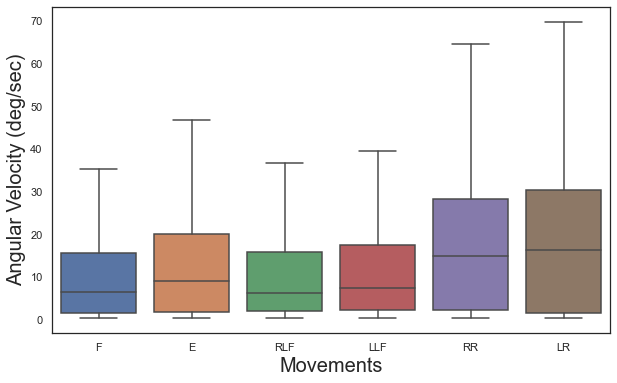

In [23]:
# RECONSTRUCTION  = {'AA': data[0],
#                    'FE': data[3],
#                    'ER': data[1],
#                    'IR': data[5],
                  
#          }
RECONSTRUCTION  = {'F': data[4],
                   'E': data[2],
                   'RLF': data[8],
                   'LLF': data[6],
                   'RR': data[9],
                   'LR': data[7],
                  
         }

df = pd.DataFrame([[label, val, 'MCP'] for label, values in RECONSTRUCTION.items() for val in values],
                  columns=['label', 'value', 'source'])



sns.set(style='white')
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df, x='label', y='value', showfliers=False, ax=ax)
# sns.swarmplot(data=df, x='label', y='value', hue='source', palette=['black', 'black'], dodge=True, legend=False, ax=ax)
# ax.set(xlabel='Movements', ylabel=' Error (deg)', fontsize=40)  # remove labels set by seaborn
ax.set_xlabel("Movements", fontsize=20)
ax.set_ylabel("Angular Velocity (deg/sec)", fontsize=20)
# sns.despine()
plt.savefig(r'D:\ROMIU\res_fig\patients\pat_rest_dev_n.svg')
plt.show()

In [219]:
data = pd.read_csv(r"D:\ROMIU\Phase2\icc\AA_icc.csv")
icc1 = pg.intraclass_corr(data=data, targets='sub', raters='clinician1', ratings='rom1')


pd.set_option('display.max_columns', 8)
pd.set_option('display.width', 200)
print(icc1)


    Type              Description       ICC          F  df1  df2          pval         CI95%
0   ICC1   Single raters absolute  0.884749  16.353425   45   46  4.169385e-17   [0.8, 0.93]
1   ICC2     Single random raters  0.885071  17.188538   45   45  2.940452e-17   [0.8, 0.94]
2   ICC3      Single fixed raters  0.890041  17.188538   45   45  2.940452e-17  [0.81, 0.94]
3  ICC1k  Average raters absolute  0.938851  16.353425   45   46  4.169385e-17  [0.89, 0.97]
4  ICC2k    Average random raters  0.939032  17.188538   45   45  2.940452e-17  [0.89, 0.97]
5  ICC3k     Average fixed raters  0.941822  17.188538   45   45  2.940452e-17  [0.89, 0.97]
